In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
columns=['sentiment','ids','date','flag','user','text']

df=pd.read_csv('Twitter_data.csv',encoding='ISO-8859-1',names=columns)

In [41]:
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [6]:
df['sentiment']=df['sentiment'].replace(4,1)

In [7]:
df['sentiment'].unique()

array([0, 1], dtype=int64)

In [8]:
df=df[['sentiment','text']]
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


[Text(0, 0, 'negative'), Text(1, 0, 'positive')]

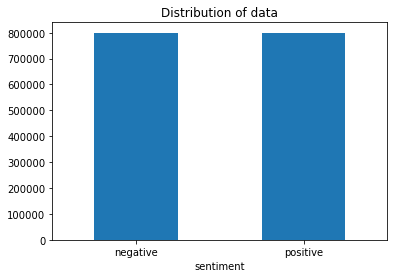

In [9]:
ax=df.groupby('sentiment').count().plot(kind='bar',title='Distribution of data',legend=False)
ax.set_xticklabels(['negative','positive'],rotation=0)

In [10]:
df=df[['text','sentiment']]

In [11]:
df_pos=df[df['sentiment']==1]

In [12]:
df_neg=df[df['sentiment']==0]

In [13]:
df_pos=df_pos[0:20000]
df_neg=df_neg[0:20000]

In [14]:
df_pos.shape

(20000, 2)

In [15]:
df=pd.concat([df_pos,df_neg],axis=0)

In [16]:
df.head()

,text,sentiment
800000,I LOVE @Health4UandPets u guys r the best!!,1
800001,im meeting up with one of my besties tonight! ...,1
800002,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
800003,Being sick can be really cheap when it hurts t...,1
800004,@LovesBrooklyn2 he has that effect on everyone,1


In [17]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [18]:
import re
import spacy
nlp=spacy.load('en_core_web_sm')
def preprocess(text):
    
    cleaned_text=text.lower()
    
    #reolace all emojis 
    for emoji in emojis.keys():   
         cleaned_text=cleaned_text.replace(emoji,"Emoji"+emojis[emoji])
    
    #rem0ve user pattern
    cleaned_text=re.sub(r'@[\w]*',' ',cleaned_text)
    
    #remove urls
    cleaned_text=re.sub(r'(http:[^ ]*)|(https:[^ ]*)|(www\.[^ ]*)','',cleaned_text)
    
    #remove punctuations
    cleaned_text=re.sub(r'[^\w\s]',' ',cleaned_text)
    
    #remove numbers
    cleaned_text=re.sub(r'[\d+]',' ',cleaned_text)
                        
    #replace 3 or more consecutive letters by 2
    cleaned_text=re.sub(r'(.)\1\1+',r'\1',cleaned_text)
    #remove 2 or more spaces
    cleaned_text=re.sub(r'[\s]+',' ',cleaned_text)
    #lemmatization
    doc=nlp(cleaned_text)
    final_text=[]                    
    for token in doc:
            if len(token)>1 and token is not token.is_stop:
                final_text.append(token.lemma_)
    return ' '.join(final_text)                          

In [19]:
df['text']=df['text'].apply(preprocess)

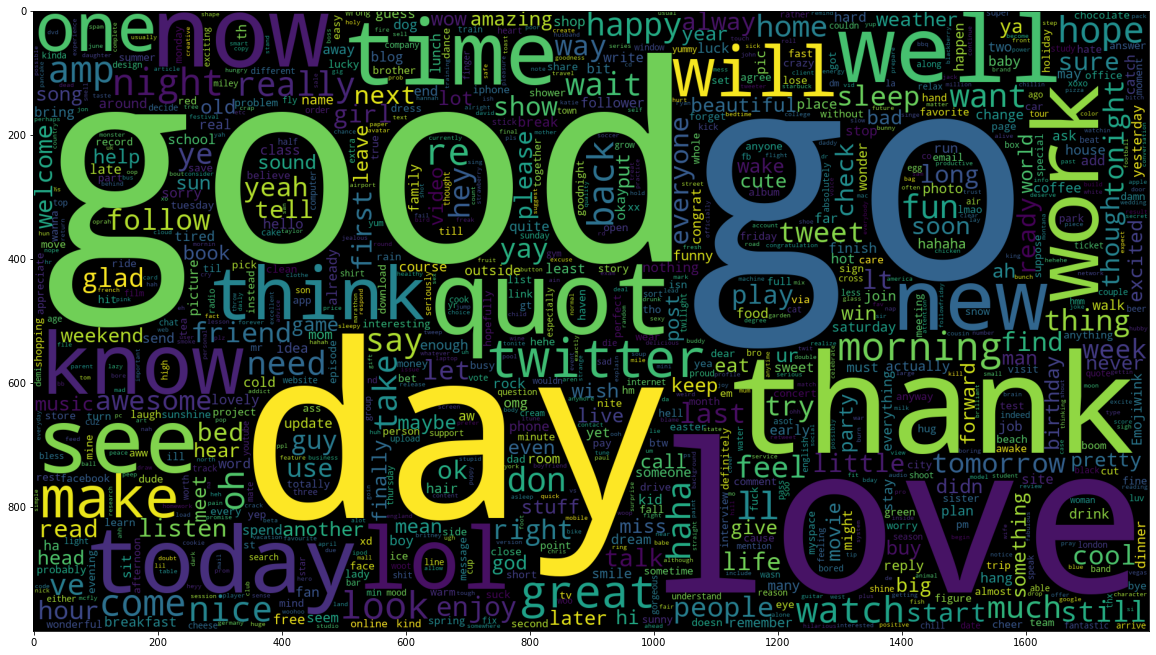

In [20]:
from wordcloud import WordCloud
df_pos=df[df['sentiment']==1]
plt.figure(figsize=(20,20))
wordcloud_pos=WordCloud(max_words=1000,width=1800,height=1000,collocations=False).generate(" ".join(df_pos['text']))
plt.imshow(wordcloud_pos)

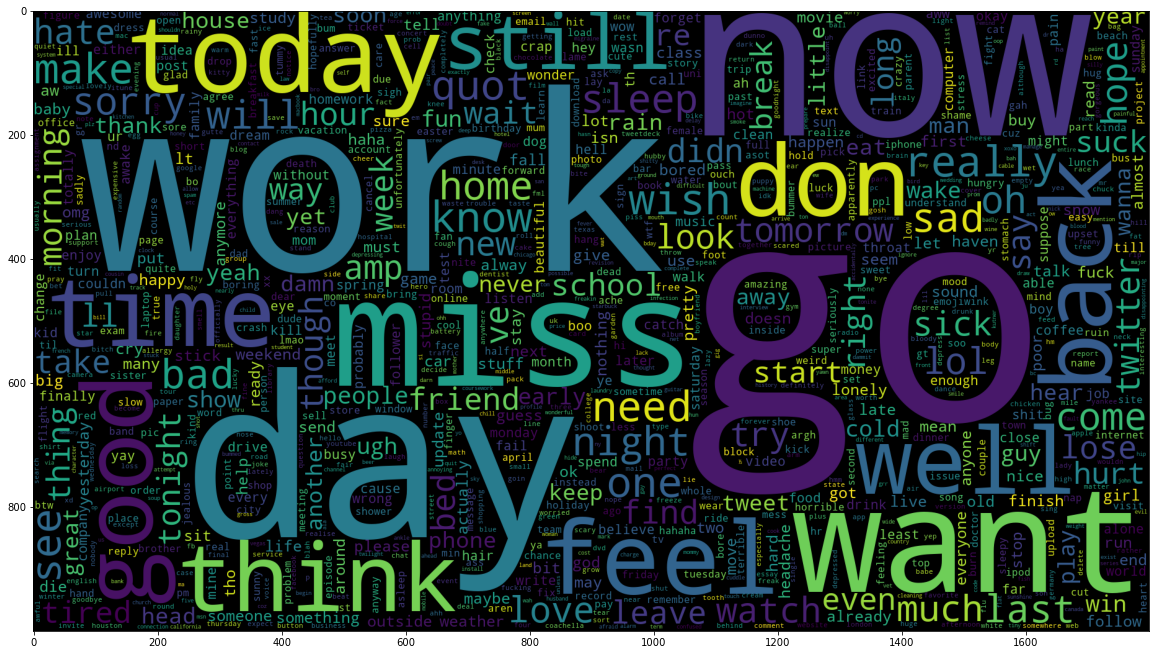

In [21]:
df_neg=df[df['sentiment']==0]
plt.figure(figsize=(20,20))
wordcloud_neg=WordCloud(max_words=1000,width=1800,height=1000,collocations=False).generate(" ".join(df_neg['text']))
plt.imshow(wordcloud_neg)

### Train Test split

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df['text'],df['sentiment'],test_size=0.2,random_state=100)


In [23]:

from sklearn.feature_extraction.text import TfidfVectorizer
vec=TfidfVectorizer(ngram_range=(1,2),max_features=50000)
X_train=vec.fit_transform(X_train)
X_test=vec.transform(X_test)

In [35]:
X_train=X_train.toarray()
X_test=X_test.toarray()

In [36]:
model=Sequential()
model.add(Dense(100,activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(40,activation='sigmoid'))
model.add(Dropout(0.3))

#hidden layer3

model.add(Dense(20,activation='sigmoid'))

#hidden layer4

model.add(Dense(30,activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.2))

#output layer

model.add(Dense(1,))

In [37]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [42]:
model.fit(X_train,y_train,epochs=50,batch_size=50)

Epoch 1/50
640/640 [==============================] - 74s 84ms/step - loss: 2.9608 - accuracy: 0.5206
Epoch 2/50
640/640 [==============================] - 52s 81ms/step - loss: 1.7016 - accuracy: 0.6148
Epoch 3/50
640/640 [==============================] - 53s 82ms/step - loss: 1.1779 - accuracy: 0.6993
Epoch 4/50
640/640 [==============================] - 51s 80ms/step - loss: 0.9205 - accuracy: 0.7687
Epoch 5/50
640/640 [==============================] - 52s 82ms/step - loss: 0.8037 - accuracy: 0.8052
Epoch 6/50
640/640 [==============================] - 50s 79ms/step - loss: 0.6577 - accuracy: 0.8315
Epoch 7/50
640/640 [==============================] - 51s 80ms/step - loss: 0.5350 - accuracy: 0.8622
Epoch 8/50
640/640 [==============================] - 52s 81ms/step - loss: 0.6006 - accuracy: 0.8509
Epoch 9/50
640/640 [==============================] - 52s 81ms/step - loss: 0.4266 - accuracy: 0.8753
Epoch 10/50
640/640 [==============================] - 50s 77ms/step - loss: 0.357

In [57]:
y_pred=model.predict(X_test)

250/250 [==============================] - 12s 13ms/step


In [62]:
y_pred[0:5]

array([[-0.67707455],
       [ 2.8240814 ],
       [ 2.0292284 ],
       [ 2.7915275 ],
       [ 2.3843963 ]], dtype=float32)

In [59]:
y_predict = []
for element in y_pred:
    if element > 0.5:
        y_predict.append(1)
    else:
        y_predict.append(0)

In [63]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      4015
           1       0.73      0.74      0.74      3985

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



Text(69.0, 0.5, 'Truth')

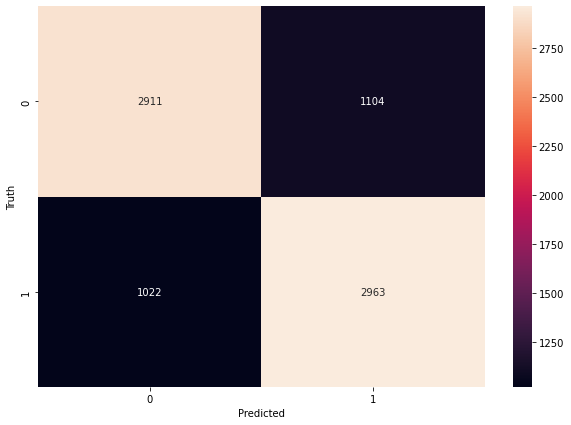

In [82]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predict)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')